# SDG 15.3.1 Error Recode Script Example

This notebook demonstrates how to use the SDG 15.3.1 error recode script via the trends.earth API. The script supports both single-period and multi-period land degradation jobs and allows for recoding specific areas based on error polygons.

## 1. Setup Environment and Import Libraries

Before running this notebook, make sure you have:

1. **Installed dependencies**: `pip install -r requirements.txt`
2. **Created environment file**: Copy `.env.example` to `.env` and update with your credentials:
   ```bash
   cp .env.example .env
   ```
3. **Updated credentials** in the `.env` file:
   ```
   API_BASE_URL=https://api.trends.earth
   API_USERNAME=your_actual_username
   API_PASSWORD=your_actual_password
   ```

In [20]:
import warnings
from pprint import pprint

from dotenv import load_dotenv
from error_recode_utils import create_error_recode_params

load_dotenv()

from trendsearth_api import TrendsEarthAPIClient  # noqa: E402

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

print("Libraries imported successfully!")
print("Environment variables loaded from .env file")

Libraries imported successfully!
Environment variables loaded from .env file


## 2. Configure API Connection and Authentication

In [21]:
# Initialize the API client
api_client = TrendsEarthAPIClient()

# Authenticate using environment variables from .env file
if api_client.authenticate_from_env():
    print("Ready to submit error recode jobs!")
    session = api_client.session  # For compatibility with existing code
else:
    print("Authentication failed - check your .env file")
    print("Please ensure your .env file contains:")
    print("- API_USERNAME=your_username")
    print("- API_PASSWORD=your_password")
    print("- API_BASE_URL=https://api.trends.earth (optional)")
    session = None

Using API URL from environment: https://api.trends.earth
Authenticating with Trends.Earth API...
   Using email: trends.earth-prais-server@trends.earth
Successfully authenticated with Trends.Earth API
Ready to submit error recode jobs!


## 3. Define Example Parameters for Error Recoding

### Error Recode Job Input Parameters

The SDG 15.3.1 error recode script accepts the following input parameters:

#### Core Job Parameters

- **`iso`** (string): ISO 3166-1 alpha-3 country code (e.g., "ATG" for Antigua and Barbuda)
- **`boundary_dataset`** (string): Administrative boundary dataset to use (e.g., "UN")
- **`write_tifs`** (boolean): Whether to write output as GeoTIFF files (`true` or `false`)
- **`include_polygon_geojson`** (boolean): Whether to include the original error polygons GeoJSON as a VectorResults in the output (`true` or `false`, default: `false`). When `true`, the algorithm returns both RasterResults (the recoded rasters) and VectorResults (the original error polygons GeoJSON saved to cloud storage).

#### Error Polygons Structure

The **`error_polygons`** parameter must be a valid GeoJSON FeatureCollection with the following structure (also see the documentation for [ErrorRecodePolygons](https://trendsearth-schemas.readthedocs.io/en/latest/api/error_recode.html#te_schemas.error_recode.ErrorRecodePolygons)):

```json
{
    "type": "FeatureCollection",
    "name": "descriptive_name",
    "crs": {
        "type": "name",
        "properties": {"name": "urn:ogc:def:crs:OGC:1.3:CRS84"}
    },
    "features": [...]
}
```

#### Error Feature Properties

Each feature in the `error_polygons` collection supports these properties  (also see the documentation for [ErrorRecodeProperties](https://trendsearth-schemas.readthedocs.io/en/latest/api/error_recode.html#te_schemas.error_recode.ErrorRecodeProperties)):

**Required Properties:**
- **`uuid`** (string): Unique identifier for the error polygon

- **`type`** (string): Must be "Feature"

- **`recode_deg_to`** (integer or null): What to recode degraded pixels to
  - `null` or `None`: No change (default)
  - `-32768`: No data
  - `0`: Stable
  - `1`: Improved

- **`recode_stable_to`** (integer or null): What to recode stable pixels to
  - `null` or `None`: No change (default)
  - `-32768`: No data
  - `-1`: Degraded
  - `1`: Improved

- **`recode_imp_to`** (integer or null): What to recode improved pixels to
  - `null` or `None`: No change (default)
  - `-32768`: No data
  - `-1`: Degraded
  - `0`: Stable

- **`periods_affected`** (array): List of periods to apply the recode to
  - `["baseline"]`: Apply to baseline period only
  - `["report_2"]`: Apply to report 2 only
  - `["baseline", "report_2"]`: Apply to multiple periods

**Descriptive Properties (Optional):**
- **`location_name`** (string): Human-readable name for the error area
- **`area_km_sq`** (number): Area of the polygon in square kilometers
- **`process_driving_change`** (string): Description of what caused the misclassification
- **`basis_for_judgement`** (string): Justification for making the correction


#### Geometry Requirements

In [32]:
params_atg = create_error_recode_params(
    "ATG", "error_polygons_antigua_barbuda.geojson", include_polygon_geojson=True
)
print(
    f"Antigua & Barbuda: {len(params_atg['error_polygons']['features'])} error polygons"
)

params_ken = create_error_recode_params(
    "KEN", "error_polygons_kenya.geojson", include_polygon_geojson=True
)
print(f"Kenya: {len(params_ken['error_polygons']['features'])} error polygons")

params_tkm = create_error_recode_params(
    "TKM", "error_polygons_turkmenistan.geojson", include_polygon_geojson=True
)
print(f"Turkmenistan: {len(params_tkm['error_polygons']['features'])} error polygons")

params_col = create_error_recode_params(
    "COL", "error_polygons_colombia.geojson", include_polygon_geojson=True
)
print(f"Colombia: {len(params_col['error_polygons']['features'])} error polygons")


# params = params_atg
# params = params_ken
# params = params_tkm
params = params_col

Antigua & Barbuda: 3 error polygons
Kenya: 3 error polygons
Turkmenistan: 3 error polygons
Colombia: 4 error polygons


## 4. Submit Job Execution to API

In [33]:
import json

if api_client.access_token:
    print(" Submitting error recode job...")
    execution_id = api_client.submit_job("unccd-sdg-15-3-1-error-recode-2-2-2", params)

    if execution_id:
        print("Job submitted. Monitoring job status...")

        # Monitor the job until completion
        final_status = api_client.monitor_job(execution_id, max_minutes=15)

        if final_status:
            status = final_status.get("status", "unknown").upper()
            if status in ["SUCCESS", "FINISHED"]:
                print("SUCCESS: Error recode job completed successfully!")

                # The results should be available in the job data
                results = final_status.get("results", {})
                if results:
                    print("Results available")
                    pprint(results)

                    # Save results to JSON file
                    iso = params.get("iso", "unknown")
                    results_filename = f"error_recode_results_{iso}.json"
                    with open(results_filename, "w") as f:
                        json.dump(results, f, indent=2)
                    print(f"Results saved to {results_filename}")
                else:
                    print("No results data found in job response")
        else:
            print("ERROR: Failed to monitor job")
    else:
        print("ERROR: Failed to submit job")
else:
    print("ERROR: Cannot submit job: not authenticated")
    print("Please check your credentials and authentication")

 Submitting error recode job...
Job submitted. Monitoring job status...
Status: READY
Status: RUNNING
Status: RUNNING
Status: RUNNING
Status: RUNNING
Status: RUNNING
Status: RUNNING
Status: RUNNING
Status: RUNNING
Status: RUNNING
Status: RUNNING
Status: RUNNING
Status: RUNNING
Status: RUNNING
Status: RUNNING
Status: RUNNING
Status: FINISHED
Job completed successfully!
SUCCESS: Error recode job completed successfully!
Results available
[{'data': {'additional_summaries': [{'areas': [{'area': 87987.01665437447,
                                                'name': 'Persistent '
                                                        'degradation'},
                                               {'area': 103895.98670132479,
                                                'name': 'Recent degradation'},
                                               {'area': 158961.09748521697,
                                                'name': 'Baseline degradation'},
                                

## 5. View results

### Output format

The SDG 15.3.1 error recode job returns results as a JSON array containing one or two elements:
1. **RasterResults**: The recoded SDG 15.3.1 indicator raster with area summaries and crosstab reports
2. **VectorResults** (optional): The original error polygons GeoJSON (only if `include_polygon_geojson=true`)

#### Main Result Structure
```json
[
  {
    "data": {
      "additional_summaries": [
        {
          "areas": [
            {"area": 59.86, "name": "Persistent degradation"},
            {"area": 133.88, "name": "Recent degradation"},
            {"area": 48.07, "name": "Baseline degradation"},
            {"area": 105.33, "name": "Stability"},
            {"area": 26.57, "name": "Baseline improvement"},
            {"area": 1.18, "name": "Recent improvement"},
            {"area": 4.12, "name": "Persistent improvement"},
            {"area": 65.51, "name": "No data"}
          ],
          "name": "SDG Indicator 15.3.1 - Reporting Period 1 Status",
          "unit": "sq km"
        },
        {
          "areas": [...],
          "name": "SDG Indicator 15.3.1 - Reporting Period 2 Status",
          "unit": "sq km"
        }
      ],
      "report": {
        "crosstabs": [
          {
            "from_period": "baseline",
            "to_period": "report_1",
            "total_area_km2": 446.375,
            "transitions": {
              "degraded": {
                "degraded": {"area_km2": 66.395, "area_pct": 14.87},
                "improved": {"area_km2": 0.296, "area_pct": 0.07},
                "nodata": {"area_km2": 0.0, "area_pct": 0.0},
                "stable": {"area_km2": 63.794, "area_pct": 14.29}
              },
              "improved": {
                "degraded": {"area_km2": 25.0, "area_pct": 5.6},
                "improved": {"area_km2": 4.138, "area_pct": 0.93},
                "nodata": {"area_km2": 0.0, "area_pct": 0.0},
                "stable": {"area_km2": 15.37, "area_pct": 3.44}
              },
              "nodata": {
                "degraded": {"area_km2": 0.961, "area_pct": 0.22},
                "improved": {"area_km2": 0.0, "area_pct": 0.0},
                "nodata": {"area_km2": 64.007, "area_pct": 14.34},
                "stable": {"area_km2": 0.813, "area_pct": 0.18}
              },
              "stable": {
                "degraded": {"area_km2": 103.162, "area_pct": 23.11},
                "improved": {"area_km2": 0.887, "area_pct": 0.2},
                "nodata": {"area_km2": 0.0, "area_pct": 0.0},
                "stable": {"area_km2": 101.551, "area_pct": 22.75}
              }
            }
          },
          {
            "from_period": "baseline",
            "to_period": "report_2",
            "total_area_km2": 446.375,
            "transitions": {...}
          }
        ]
      },
      "summary": {
        "areas": [
          {"area": 44.51, "name": "Improved"},
          {"area": 181.53, "name": "Stable"},
          {"area": 130.49, "name": "Degraded"},
          {"area": 65.78, "name": "No data"}
        ],
        "name": "SDG Indicator 15.3.1 - Baseline",
        "unit": "sq km"
      }
    },
    "name": "SDG 15.3.1 Indicator",
    "type": "RasterResults",
    "uri": {
      "etag": {
        "hash": "4f2e8356b65af7f611e466dcaf07781d",
        "type": "AWS MD5 Etag"
      },
      "uri": "/vsis3/trends-earth-users/prais5-recode/a3768387-7137-4830-8ba0-fc43dc4d97e8_Int16.tif"
    },
    "rasters": {
      "Int16": {
        "bands": [
          {
            "activated": true,
            "add_to_map": true,
            "metadata": {"period": "Baseline", "year_final": 2015, "year_initial": 2001},
            "name": "SDG 15.3.1 Indicator",
            "no_data_value": -32768
          },
          {
            "activated": true,
            "add_to_map": true,
            "metadata": {...},
            "name": "SDG 15.3.1 Indicator (status)",
            "no_data_value": -32768
          },
          {
            "activated": false,
            "add_to_map": false,
            "metadata": {...},
            "name": "Error recode periods",
            "no_data_value": -32768
          }
        ],
        "datatype": "Int16",
        "extent": null,
        "filetype": "COG",
        "type": "One file raster",
        "uri": {...}
      }
    }
  },
  {
    "extent": null,
    "name": "Error recode periods",
    "type": "VectorResults",
    "vector": {
      "type": "False positive/negative",
      "uri": {
        "etag": {"hash": "cc277475f6eb86d1158ff2d53869ad37", "type": "AWS MD5 Etag"},
        "uri": "/vsis3/trends-earth-users/prais5-recode/df38f166-8add-4c4d-ba95-1c0798b93d7e_error_polygons.geojson"
      }
    }
  }
]
```

#### Key Components

**`data`** (object): Contains area summaries and crosstab reports
- **`summary`**: Baseline area statistics showing sq km of degraded/stable/improved land
- **`additional_summaries`**: Area statistics for each reporting period status (7 status categories)
- **`report.crosstabs`**: Transition matrices showing how land changed between periods

**`name`** (string): Human-readable name for the result ("SDG 15.3.1 Indicator")

**`type`** (string): Result type identifier ("RasterResults" or "VectorResults")

**`uri`** (object): Contains the main result file location and metadata
- **`uri`**: VSIS3 path to the recoded multi-band GeoTIFF file  
- **`etag`**: AWS file hash for integrity verification

**`rasters`** (object): Dictionary of raster layers keyed by data type
- **`Int16`**: 16-bit signed integer raster containing all bands

#### Crosstabs Structure

The `crosstabs` array contains transition matrices for each period comparison:

**Fields:**
- **`from_period`**: Source period (always "baseline")
- **`to_period`**: Target period ("report_1" or "report_2")
- **`total_area_km2`**: Total analyzed area in square kilometers
- **`transitions`**: Nested dictionary of from-state → to-state transitions

**Transition Matrix:**
Each entry in `transitions` maps from a baseline state to reporting period states:
- `degraded` → {`degraded`, `improved`, `nodata`, `stable`}
- `improved` → {`degraded`, `improved`, `nodata`, `stable`}
- `nodata` → {`degraded`, `improved`, `nodata`, `stable`}
- `stable` → {`degraded`, `improved`, `nodata`, `stable`}

**Each transition contains:**
- **`area_km2`**: Area in square kilometers
- **`area_pct`**: Percentage of total area

#### Band Structure

The `rasters["Int16"]["bands"]` array contains 3-4 bands depending on the number of reporting periods:

1. **Baseline Indicator Band**
   - `name`: "SDG 15.3.1 Indicator"
   - Values: `-1` (degraded), `0` (stable), `1` (improved), `-32768` (no data)

2. **Reporting Period Status Band(s)**  
   - `name`: "SDG 15.3.1 Indicator (status)"
   - Values:
      - `-32768`: No data
      - `1`: Persistent degradation
      - `2`: Recent degradation
      - `3`: Baseline degradation
      - `4`: Stability
      - `5`: Baseline improvement
      - `6`: Recent improvement
      - `7`: Persistent improvement

3. **Error Recode Periods Band**
   - `name`: "Error recode periods"
   - Rasterized version of the error recoding polygons showing which periods were affected

#### VectorResults (Optional)

If `include_polygon_geojson=true`, a second result element is included:
- **`type`**: "VectorResults"
- **`vector.type`**: "False positive/negative"  
- **`vector.uri`**: VSIS3 path to the original error polygons GeoJSON file

### Plot results (needs s3 access)

Creating visualizations for Antigua and Barbuda (ATG)...
Download completed (0.0 MB)
Area statistics by band:
  Band 1 - SDG 15.3.1 Indicator - Baseline:
    No Data: 6491.550 km² (84299 pixels)
    Degraded: 114.354 km² (1485 pixels)
    Stable: 220.392 km² (2862 pixels)
    Improved: 66.995 km² (870 pixels)
  Band 2 - SDG 15.3.1 Indicator - Reporting Period 2 Status:
    No Data: 6493.475 km² (84324 pixels)
    Improved: 63.607 km² (826 pixels)
    Other (2): 163.022 km² (2117 pixels)
    Other (3): 47.205 km² (613 pixels)
    Other (4): 84.630 km² (1099 pixels)
    Other (5): 12.167 km² (158 pixels)
    Other (6): 6.700 km² (87 pixels)
    Other (7): 22.486 km² (292 pixels)
  Band 3 - Error recode:
    No Data: 6832.919 km² (88732 pixels)
    Other (21): 14.785 km² (192 pixels)
    Other (32): 25.874 km² (336 pixels)
    Other (60): 19.714 km² (256 pixels)
Visualizing 3 bands...


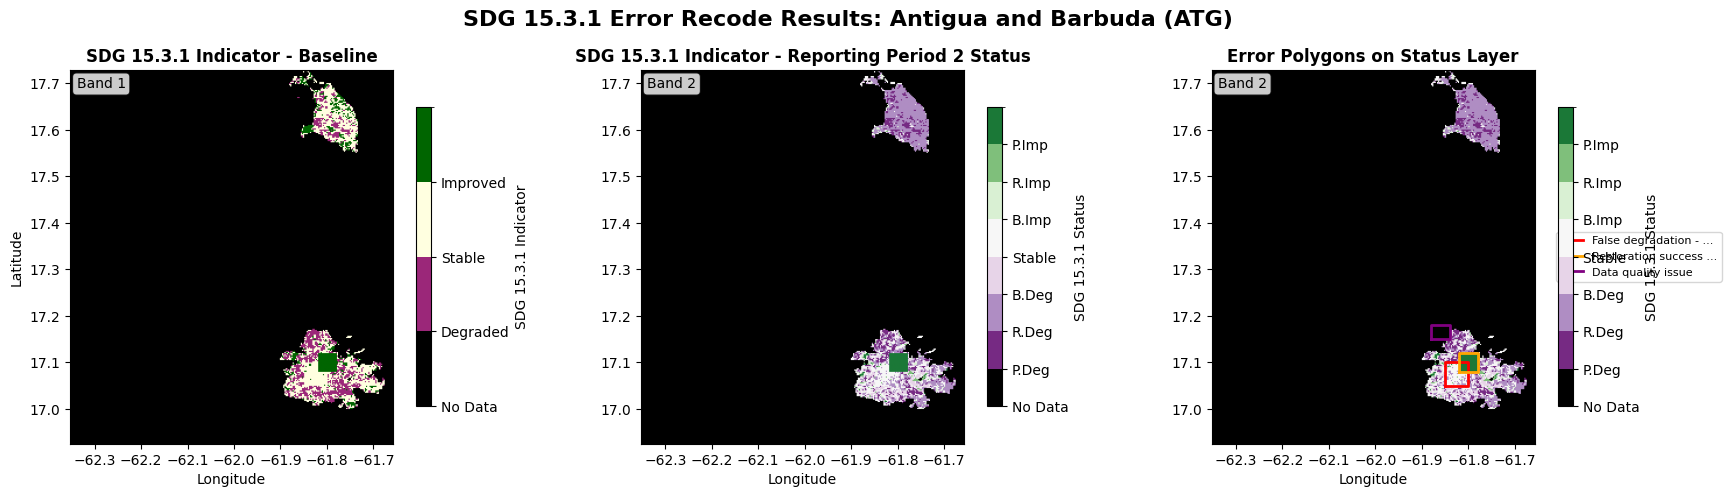

Local TIF file saved at: C:\Users\azvoleff\AppData\Local\Temp\trends_earth_8hvnr5zz\c4b4da48-aa35-43cb-a3b0-c6150cca0ae5_Int16.tif

Local TIF file available for further analysis at: C:\Users\azvoleff\AppData\Local\Temp\trends_earth_8hvnr5zz\c4b4da48-aa35-43cb-a3b0-c6150cca0ae5_Int16.tif


In [35]:
# The below code requires access to the s3 bucket where results are stored
# and will not run in the absence of valid credentials and a real job run.

import os
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import rasterio
import requests
from matplotlib.colors import BoundaryNorm, ListedColormap
from shapely.geometry import shape

# Official SDG 15.3.1 color schemes from trends.earth styles.json
sdg_indicator_colors = {
    -32768: "#000000",  # nodata - black
    -1: "#9b2779",  # degraded - dark purple
    0: "#ffffe0",  # stable - light yellow
    1: "#006500",  # improved - dark green
}

sdg_status_colors = {
    -32768: "#000000",  # nodata - black
    1: "#762a83",  # persistent degradation - dark purple
    2: "#af8dc3",  # recent degradation - medium purple
    3: "#e7d4e8",  # baseline degradation - light purple
    4: "#f7f7f7",  # stability - light gray
    5: "#d9f0d3",  # baseline improvement - light green
    6: "#7fbf7b",  # recent improvement - medium green
    7: "#1b7837",  # persistent improvement - dark green
}


def _extract_results_data(results):
    """Extract URI and band information from results."""
    s3_uri = None
    if "uri" in results:
        download_info = results["uri"]
        s3_uri = (
            download_info["uri"] if isinstance(download_info, dict) else download_info
        )

    bands_info = []
    if "rasters" in results:
        for raster_info in results["rasters"].values():
            if "bands" in raster_info:
                bands_info = raster_info["bands"]
                break

    return s3_uri, bands_info


def _download_tif_locally(tif_url, temp_dir=None):
    """Download TIF file from S3 URL to a local temporary file."""
    # Convert vsis3 path to direct S3 URL if needed
    if tif_url.startswith("/vsis3/"):
        vsis3_path = tif_url[7:]  # Remove '/vsis3/'
        parts = vsis3_path.split("/", 1)
        if len(parts) == 2:
            bucket, key = parts
            s3_url = f"https://s3.amazonaws.com/{bucket}/{key}"
        else:
            s3_url = tif_url
    else:
        s3_url = tif_url

    # Create temp directory if not provided
    if temp_dir is None:
        temp_dir = tempfile.mkdtemp(prefix="trends_earth_")
    else:
        os.makedirs(temp_dir, exist_ok=True)

    # Extract filename from URL or use default
    filename = s3_url.split("/")[-1] if "/" in s3_url else "downloaded_results.tif"
    if not filename.endswith(".tif"):
        filename = "downloaded_results.tif"

    local_path = os.path.join(temp_dir, filename)

    print(f"Downloading TIF file to: {local_path}")

    try:
        response = requests.get(s3_url, stream=True)
        response.raise_for_status()

        with open(local_path, "wb") as f:
            for chunk in response.iter_content(chunk_size=8192):
                if chunk:
                    f.write(chunk)

        file_size_mb = os.path.getsize(local_path) / (1024 * 1024)
        print(f"Download completed ({file_size_mb:.1f} MB)")
        return local_path

    except requests.exceptions.RequestException as e:
        raise RuntimeError(f"Failed to download TIF file: {str(e)}") from e


def _get_color_scheme(band_name):
    """Get appropriate color scheme based on band name."""
    if "status" in band_name.lower():
        return {
            "colors": sdg_status_colors,
            "label": "SDG 15.3.1 Status",
            "values": sorted([k for k in sdg_status_colors.keys() if k != -32768]),
            "tick_labels": [
                "No Data",
                "P.Deg",
                "R.Deg",
                "B.Deg",
                "Stable",
                "B.Imp",
                "R.Imp",
                "P.Imp",
            ],
        }
    else:
        return {
            "colors": sdg_indicator_colors,
            "label": "SDG 15.3.1 Indicator",
            "values": [-1, 0, 1],
            "tick_labels": ["No Data", "Degraded", "Stable", "Improved"],
        }


def _print_area_statistics(value, count, pixel_area_km2):
    """Print formatted area statistics for a value."""
    area_km2 = count * pixel_area_km2
    value_names = {-32768: "No Data", -1: "Degraded", 0: "Stable", 1: "Improved"}
    name = value_names.get(value, f"Other ({value})")
    print(f"    {name}: {area_km2:.3f} km² ({count} pixels)")


def visualize_error_recode_results(
    results, params, job_title=None, temp_dir=None, keep_local_file=False
):
    """
    Visualize SDG 15.3.1 error recode results with multi-band TIF file analysis and visualization.
    Downloads the TIF file locally for processing.
    """
    print(f"Creating visualizations for {job_title or 'error recode results'}...")

    # Extract and validate data from results
    s3_uri, bands_info = _extract_results_data(results)
    if not s3_uri:
        raise FileNotFoundError("No TIF file URI found in results.")
    if not bands_info:
        raise ValueError(
            "No band information found. Cannot proceed without band metadata."
        )

    # Download TIF file locally
    try:
        local_tif_path = _download_tif_locally(s3_uri, temp_dir)
    except Exception as e:
        raise RuntimeError(f"Failed to download TIF file: {str(e)}") from e

    error_polygons = params["error_polygons"]["features"]

    # Analyze bands for area statistics
    try:
        with rasterio.open(local_tif_path) as src:
            # Calculate pixel area (degrees to km approximation)
            x_pixel_size = abs(src.transform[0]) * 111.0  # ~111 km per degree
            y_pixel_size = abs(src.transform[4]) * 111.0
            pixel_area_km2 = x_pixel_size * y_pixel_size

            print("Area statistics by band:")
            for i, band_info in enumerate(bands_info, 1):
                if i <= src.count:
                    data = src.read(i)
                    if data is None or data.size == 0:
                        print(f"  Band {i} ({band_info['name']}): No valid data")
                        continue

                    unique_values, counts = np.unique(data, return_counts=True)
                    print(f"  Band {i} - {band_info['name']}:")
                    for value, count in zip(unique_values, counts):
                        _print_area_statistics(value, count, pixel_area_km2)

    except Exception as e:
        # Clean up downloaded file on error
        if os.path.exists(local_tif_path):
            try:
                os.remove(local_tif_path)
            except OSError:
                pass
        raise RuntimeError(f"Failed to analyze TIF data: {str(e)}") from e

    # Create visualizations
    print(f"Visualizing {len(bands_info)} bands...")

    # Setup subplots
    n_bands = len(bands_info)
    cols = min(n_bands, 3)
    rows = (n_bands + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows))

    if job_title:
        fig.suptitle(
            f"SDG 15.3.1 Error Recode Results: {job_title}",
            fontsize=16,
            fontweight="bold",
            y=0.98,
        )

    # Normalize axes to always be a list
    if n_bands == 1:
        axes = [axes]
    elif rows == 1:
        axes = list(axes) if n_bands > 1 else [axes]
    else:
        axes = axes.flatten()

    try:
        with rasterio.open(local_tif_path) as src:
            for plot_idx, (band_idx, band_info) in enumerate(
                [(i + 1, band) for i, band in enumerate(bands_info)]
            ):
                # Special handling for third plot - use status band as background
                if plot_idx == 2:
                    for i, band in enumerate(bands_info, 1):
                        if (
                            "status" in band["name"].lower()
                            and "reporting" in band["name"].lower()
                        ):
                            data = src.read(i)
                            band_info = band
                            band_idx = i
                            break
                    else:
                        data = src.read(band_idx)
                else:
                    data = src.read(band_idx)

                # Validate data
                if data is None or data.size == 0:
                    raise ValueError(
                        f"Empty data in band {band_idx}: {band_info['name']}"
                    )

                # Handle nodata values
                nodata_value = band_info.get("no_data_value", -32768)
                data = np.where(data == src.nodata, nodata_value, data)

                # Get color scheme and create colormap
                scheme = _get_color_scheme(band_info["name"])
                colors_list = [scheme["colors"][-32768]] + [
                    scheme["colors"][v] for v in scheme["values"]
                ]
                bounds = [-32768] + scheme["values"] + [scheme["values"][-1] + 1]
                ticks = [-32768] + scheme["values"]

                cmap = ListedColormap(colors_list)
                norm = BoundaryNorm(bounds, cmap.N)

                # Create plot
                im = axes[plot_idx].imshow(
                    data,
                    cmap=cmap,
                    norm=norm,
                    extent=[
                        src.bounds.left,
                        src.bounds.right,
                        src.bounds.bottom,
                        src.bounds.top,
                    ],
                )

                # Set titles and labels
                title = (
                    "Error Polygons on Status Layer"
                    if plot_idx == 2
                    else band_info["name"]
                )
                axes[plot_idx].set_title(title, fontsize=12, fontweight="bold")
                axes[plot_idx].set_xlabel("Longitude")
                if plot_idx % cols == 0:
                    axes[plot_idx].set_ylabel("Latitude")

                # Add polygon overlays for third plot
                if plot_idx == 2:
                    polygon_colors = ["red", "orange", "purple", "green", "pink"]
                    for i, polygon in enumerate(error_polygons):
                        color = polygon_colors[i % len(polygon_colors)]
                        location_name = polygon["properties"].get(
                            "location_name", f"Error Polygon {i + 1}"
                        )
                        poly_geom = shape(polygon["geometry"])

                        if poly_geom.geom_type == "Polygon":
                            coords = list(poly_geom.exterior.coords)
                            x_coords, y_coords = zip(*coords)
                            label = (
                                f"{location_name[:20]}..."
                                if len(location_name) > 20
                                else location_name
                            )
                            axes[plot_idx].plot(
                                x_coords,
                                y_coords,
                                color=color,
                                linewidth=2,
                                label=label,
                            )

                    axes[plot_idx].legend(
                        bbox_to_anchor=(1.05, 0.5), loc="center left", fontsize=8
                    )

                # Add colorbar
                cbar = plt.colorbar(im, ax=axes[plot_idx], ticks=ticks, shrink=0.8)
                cbar.set_ticklabels(scheme["tick_labels"][: len(ticks)])
                cbar.set_label(scheme["label"], fontsize=10)

                # Add band number info
                axes[plot_idx].text(
                    0.02,
                    0.98,
                    f"Band {band_idx}",
                    transform=axes[plot_idx].transAxes,
                    verticalalignment="top",
                    bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
                )

    except Exception as e:
        # Clean up downloaded file on error
        if os.path.exists(local_tif_path) and not keep_local_file:
            try:
                os.remove(local_tif_path)
            except OSError:
                pass
        raise RuntimeError(f"Failed to process TIF file: {str(e)}") from e

    # Hide unused subplots and display
    for i in range(n_bands, len(axes)):
        axes[i].set_visible(False)

    plt.tight_layout()
    plt.show()

    # Clean up or return path based on keep_local_file parameter
    if keep_local_file:
        print(f"Local TIF file saved at: {local_tif_path}")
        return local_tif_path
    else:
        try:
            os.remove(local_tif_path)
            print("Temporary TIF file cleaned up")
        except Exception as e:
            print(f"Warning: Could not remove temporary file {local_tif_path}: {e}")
        return None


# Call the function with the current results and parameters
local_file_path = visualize_error_recode_results(
    results, params, f"Antigua and Barbuda ({params['iso']})", keep_local_file=True
)

if local_file_path:
    print(f"\nLocal TIF file available for further analysis at: {local_file_path}")